# Predicting number of COVID-19 cases in the state of São Paulo, Brazil.

Author: Felipe Maia Polo

Contact: felipemaiapolo@gmail.com

Site: https://felipemaiapolo.github.io

This notebook is extension of this work https://github.com/pdpcosta/COVID-19_Brazil/blob/master/COVID_19_Brasil_States.ipynb and I used their dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unidecode
import seaborn as sns
#import statsmodels.api as sm
import pystan
from pystan import StanModel
#from scipy.stats import uniform, norm
import arviz as az
import warnings
import seaborn as sns
#import math
import time
import datetime

Opening the dataset

In [2]:
url='https://raw.githubusercontent.com/pdpcosta/COVID-19_Brazil/master/COVID-19_Brazil_States_CONFIRMED.csv'
df=pd.read_csv(url)
df['Date']=pd.to_datetime(df['Date'])
df=df.dropna()
topfivestates=df[df.Date==pd.Timestamp(2020,3,23)].sort_values('Confirmed',ascending = False).head(5)
print ("Top 5 States in Number of Cases\n",topfivestates)

Top 5 States in Number of Cases
         Region State       Date  Confirmed
753  Southeast    SP 2020-03-23      745.0
550  Southeast    RJ 2020-03-23      233.0
172  Northeast    CE 2020-03-23      164.0
201    Midwest    DF 2020-03-23      146.0
317  Southeast    MG 2020-03-23      128.0


Getting the data for São Paulo state ready

In [3]:
sp=df[df.State=="SP"]
days_sp=np.asarray(range(len(sp)))
sp_epidemy=sp[(sp['Confirmed']>0)]

n1state=topfivestates["State"].iloc[0]
n2state=topfivestates["State"].iloc[1]
n3state=topfivestates["State"].iloc[2]
n4state=topfivestates["State"].iloc[3]
n5state=topfivestates["State"].iloc[4]

confirmedn1=df[(df['State']==n1state)]
confirmedn2=df[(df['State']==n2state)]
confirmedn3=df[(df['State']==n3state)]
confirmedn4=df[(df['State']==n4state)]
confirmedn5=df[(df['State']==n5state)]

sp=df[df.State=="SP"]

sp_epidemy=sp[(sp['Confirmed']>0)]
sp_day1=sp_epidemy['Date'].iloc[0]
sp_day1=sp_day1-pd.Timedelta(days=1)
sp_epidemy=sp[(sp['Date']>=sp_day1)]

days1=np.asarray(range(len(sp_epidemy)))[1:] # SP is the first state with epidemy in Brazil
days=np.asarray(range(60))+1

We have data for the 28 days since the first case in SP, which was in 26/02/2020. Then we define the time vector $T=(1,...,28)$ and a vector of the number of cases in SP since 26/02/2020 $y=(y_1,...,y_{28})$.

In [7]:
T=days1
y=np.array(sp_epidemy['Confirmed'])[1:]

In [8]:
T,y

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([  1.,   1.,   1.,   2.,   2.,   2.,   2.,   3.,   6.,  10.,  13.,
         16.,  16.,  19.,  30.,  46.,  56.,  65., 136., 152., 164., 240.,
        286., 396., 459., 631., 745., 810.]))

Plotting the data:

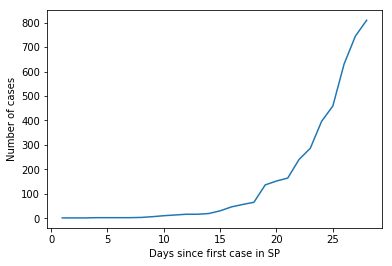

In [9]:
plt.plot(T,y)
plt.xlabel("Days since first case in SP")
plt.ylabel("Number of cases")
plt.show()

It is possible to see an exponential trend. I am assuming the exponential trend we continue for the next weeks and we are going to use the exponential function to model out variable of interest. The exponential function can be defined as follows:

\begin{align}
    f(t,K,\beta_1)&=K \cdot \text{exp}[\beta_1 \cdot t] \\ \\
\end{align}

With $K>0$ being a positive random variable and $\beta_1>0$ being the random growth rate. Adding a stochastic term $\varepsilon>0$ to our equation, we get


\begin{align}
    f(t,K,\beta_1, \varepsilon)&=K \cdot \varepsilon \cdot \text{exp}[\beta_1 \cdot t] \\ \\
\end{align}

We define $\varepsilon$ as being LogNormal random variable with parameters $0$ and $\sigma^2$, that is $\varepsilon \sim \text{LogNormal}(0,\sigma^2)$. Taking the log in both sides, we get

\begin{align}
    \tilde{f}(t,K,\beta_1, \varepsilon)&=\text{log}[f(t,K,\beta_1, \varepsilon)]\\ \\
    &=\text{log}(K)+ \beta_1 \cdot t + \varepsilon\\ \\
    &=\beta_0+ \beta_1 \cdot t + \varepsilon \\ \\
\end{align}

With $\beta_0=\text{log}(K)$ and $\tilde{\varepsilon}=\text{log}(\varepsilon) \sim N(0,\sigma^2)$. If we define $\tilde{y}=\text{log}(y)$, we are modelling our variable of interest in the following way:

\begin{align}
    \tilde{y}|t,\beta_0,\beta_1,\sigma \sim N\Big(\beta_0+ \beta_1 \cdot t, \sigma^2 \Big)
\end{align}


Let's visualize the log of the number of cases:

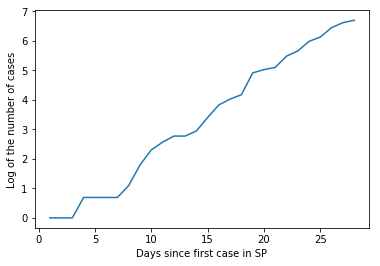

In [51]:
log_y=np.log(np.array(sp_epidemy['Confirmed'])[1:])

plt.plot(T,log_y)
plt.xlabel("Days since first case in SP")
plt.ylabel("Log of the number of cases")
plt.show()

We define the following prior distributions for our parameters:

- $\beta_0 \sim \text{N}(0,1)$ 
- $\beta_1 \sim \text{Truncated_Normal}(0,1,0,\infty)$
- $\sigma \sim \text{IG}(1,1)$

I am going to use PyStan to calculate the posteriors. Setting up:

In [65]:
# Data
np.random.seed(1056) # set seed to replicate example                                                                                                      # random normal variate 

# Fit
stan_data = {}                     # build data dictionary
stan_data['nobs'] = np.shape(T)[0] # sample size
stan_data['t'] = T                 # explanatory variable         
stan_data['log_y'] = log_y             # response variable
stan_data['k'] = 1    # number of explanatory variables

Number of iterations:

In [66]:
itera=72500
thin=25
chains=4
burn=10000

print("Number of draws=",(itera-burn)/thin*chains)

Number of draws= 10000.0


Defining our model:

In [67]:
# Stan code
stan_code = """
data {
    int<lower=1> k;  
    int<lower=0> nobs;                                 
    vector[nobs] t;                     
    vector[nobs] log_y;                     
}
parameters {  
    real beta0;   
    real<lower=0> beta1; 
    real<lower=0> sigma;               
}
model {
    sigma ~ inv_gamma(1, 1);
    beta0~normal(0,1);
    beta1~normal(0,1);
    
    log_y ~ normal(beta0 + beta1*t, sigma);       
}
"""

Fitting the model:

In [68]:
start = time.time()

fit=pystan.stan(model_code=stan_code, data=stan_data, iter=itera, thin=thin, control={'adapt_delta':.99},
                   chains=chains, warmup=burn, n_jobs=-1, verbose=False)

end = time.time()
print('minutes=',(end - start)/60)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a480e07aaadd7db90086157fce152b3 NOW.


minutes= 1.4686437527338663


A summary:

In [74]:
print(fit)

Inference for Stan model: anon_model_2a480e07aaadd7db90086157fce152b3.
4 chains, each with iter=72500; warmup=10000; thin=25; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0  -0.65 10.0e-4    0.1  -0.84  -0.71  -0.65  -0.58  -0.45   9782    1.0
beta1   0.27  5.9e-5 5.9e-3   0.26   0.27   0.27   0.28   0.28   9943    1.0
sigma   0.25  3.7e-4   0.04   0.19   0.23   0.25   0.27   0.34  10011    1.0
lp__   22.28    0.01   1.29  18.94  21.71  22.63  23.21  23.75   9812    1.0

Samples were drawn using NUTS at Wed Mar 25 21:14:15 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Trace plots:

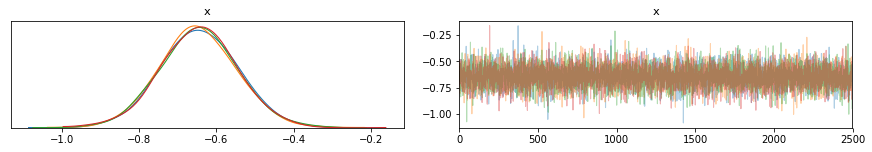

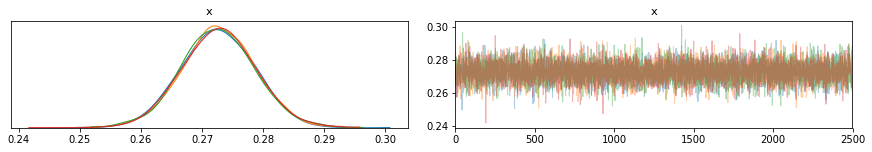

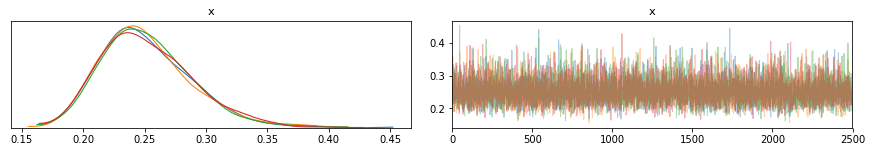

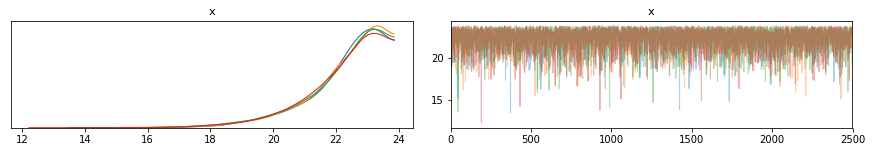

In [75]:
posterior_chains=np.transpose(fit.extract(permuted=False), (1, 0, 2))

warnings.filterwarnings("ignore")
for i in range(4):
    az.plot_trace(posterior_chains[:,:,i])
    plt.show()

Looking to Rhat and traceplots, it seems our chain has converged. Also, no convergence issues were detected by Stan.

Out main interest we be in the distribution of the **expected** number of cases. Mathematically, we will be interested in the distribution of the following random variable:

\begin{align}
 \mu(t)_{K,\beta_1}&=\mathbb{E}\Big[f(t,K,\beta_1,\varepsilon )|K,\beta_1 \Big] \\ \\
 &=\mathbb{E}\Big[K \cdot \varepsilon \cdot \text{exp}[\beta_1 \cdot t] |K,\beta_1 \Big] \\ \\
 &=K \cdot \text{exp}[\beta_1 \cdot t] \cdot \mathbb{E}\Big[\varepsilon |K,\beta_1 \Big] \\ \\
 &=K \cdot \text{exp}[\beta_1 \cdot t] \cdot \mathbb{E}_\sigma\Big[\mathbb{E}_{\varepsilon|\sigma}\Big[\varepsilon |\sigma \Big] \Big] \\ \\
 &=K \cdot \text{exp}[\beta_1 \cdot t] \cdot \mathbb{E}_\sigma\Big[\text{exp}( \sigma^2/2) \Big] \\ \\
 &\approx K \cdot \text{exp}[\beta_1 \cdot t] \cdot \Big[ \frac{1}{L}\sum_{l=1}^L\text{exp}( \sigma_l^2/2) \Big] \\ \\
\end{align}

$K$ and $\beta_1$ being distributed according to their posterior distributions and $\sigma_l^2$ instances of its posterior $L$ simulations.

Extracting the posterior distribution of parameters:

In [79]:
posterior=fit.extract()
K=np.exp(posterior['beta0'])
beta1=posterior['beta1']

esp_eps=np.mean(np.exp((posterior['sigma']**2)/2))

Defining $\mu$:

In [88]:
def mu(t,K,beta1): return K*np.exp(beta1*t)*esp_eps

In [89]:
output=[]

for t in days: output.append(mu(t,K,beta1).tolist())

output=np.array(output)

np.shape(output)

(60, 10000)

Possible scenarios:

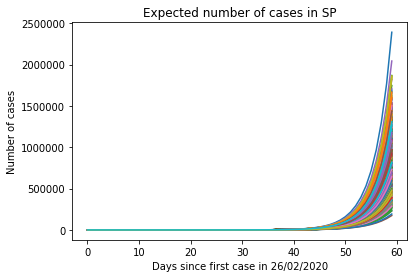

In [90]:
plt.plot(output[:,:10000]/10)
plt.title("Expected number of cases in SP")
plt.xlabel("Days since first case in 26/02/2020")
plt.ylabel("Number of cases")
plt.savefig('covid.png', dpi=None)
plt.show()

Main plots:

In [91]:
format_str = '%d/%m/%Y' # The format

def date_delta(dias, start_date): 
    date_1 = datetime.datetime.strptime(start_date, "%d/%m/%Y")
    end_date = date_1 + datetime.timedelta(days=dias)
    return end_date.strftime("%d/%m/%Y")

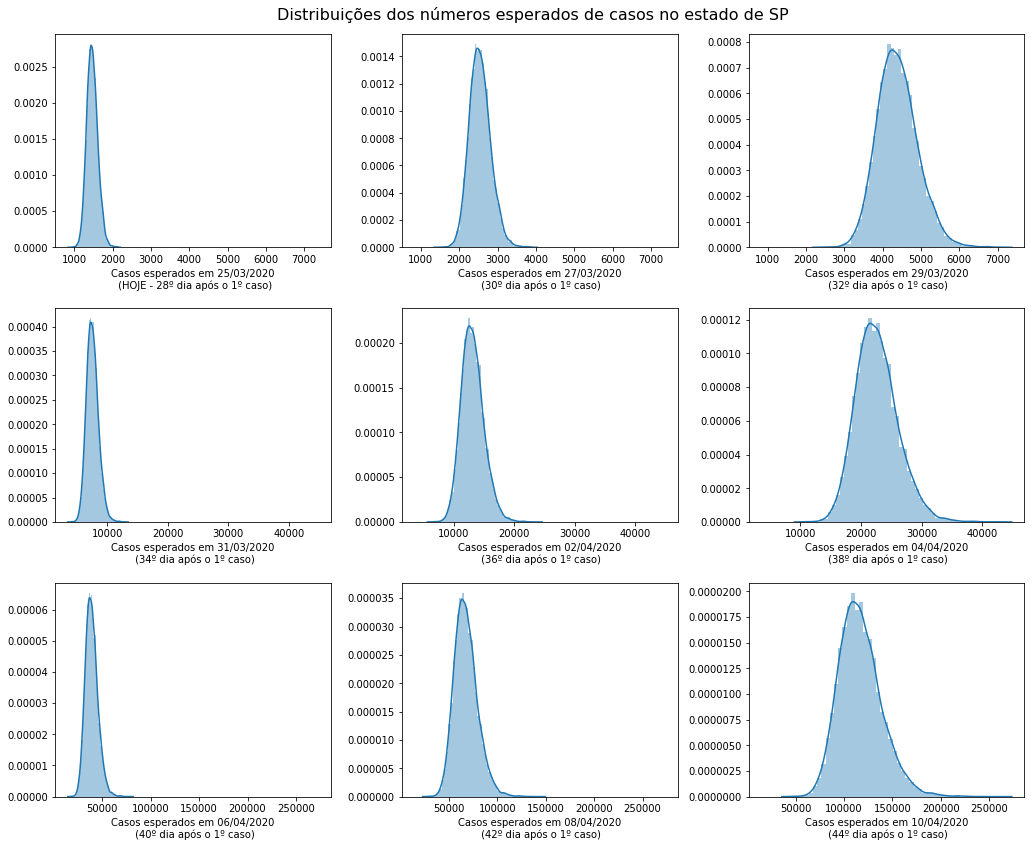

In [92]:
f, axes = plt.subplots(3, 3, figsize=(15, 12),sharex='row')
plt.tight_layout(pad=4.0)
plt.suptitle('Distribuições dos números esperados de casos no estado de SP', fontsize=16)

t=28
sns.distplot(output[t,:], ax=axes[0, 0],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n (HOJE - "+str(t)+"º dia após o 1º caso)")

t=30
sns.distplot(output[t,:], ax=axes[0, 1],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=32
sns.distplot(output[t,:], ax=axes[0, 2],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=34
sns.distplot(output[t,:], ax=axes[1, 0],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=36
sns.distplot(output[t,:], ax=axes[1, 1],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=38
sns.distplot(output[t,:], ax=axes[1, 2],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=40
sns.distplot(output[t,:], ax=axes[2, 0],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=42
sns.distplot(output[t,:], ax=axes[2, 1],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

t=44
sns.distplot(output[t,:], ax=axes[2, 2],axlabel="Casos esperados em "+date_delta(t,'26/02/2020')+"\n ("+str(t)+"º dia após o 1º caso)")

#plt.savefig('covid3.png', dpi=None)
        
plt.show()